# **Brain Tumor Classifier**
## **Datasets**
 - Figshare: [Brain tumor dataset](https://figshare.com/articles/dataset/brain_tumor_dataset/1512427/5)
 - Kaggle: [Brain Tumor Classification (MRI)](https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri)



In [ ]:
import h5py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report,precision_recall_fscore_support
import tensorflow as tf
import seaborn as sns
from tensorflow.keras import Sequential
from tensorflow.keras.layers import InputLayer, Reshape, Flatten, Dense, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, BatchNormalization
from tensorflow.keras.layers import Rescaling
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import RandomFlip, RandomTranslation, RandomRotation, RandomZoom, RandomContrast, RandomCrop
from datetime import datetime
import time

In [ ]:
def plots(history, xlim=None, ylim=None):
  if hasattr(history, 'history'):
    history = history.history
  plt.figure(figsize=(14, 4))
  plt.subplot(1, 2, 1)
  plt.plot(history['loss'], '.-', label='Train loss')
  if 'val_loss' in history.keys():
    plt.plot(history['val_loss'], '.-', label='Val loss')
  plt.xlabel('Epochs');
  plt.legend();
  plt.yscale('log')
  plt.grid(which='both');
  plt.subplot(1, 2, 2)
  plt.plot(history['accuracy'], '.-', label='Train accuracy')
  plt.xlabel('Epochs');
  if 'val_accuracy' in history.keys():
    plt.plot(history['val_accuracy'], '.-', label='Val accuracy')
    plt.title(f"Val accuracy: {np.max(history['val_accuracy']):.1%} (best) | {history['val_accuracy'][-1]:.1%} (last)");
  plt.legend();
  plt.xlim(xlim);
  plt.ylim(ylim);
  plt.grid()

In [ ]:
def load_mat(file_path):
    data = {}
    with h5py.File(file_path, 'r') as file:
        def process_object(name, obj):
            if isinstance(obj, h5py.Group):
                data[name] = {}
                obj.visititems(process_object)
            else:
                data[name] = obj[()]

        file.visititems(process_object)

    return data

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# **Carregamento e Processamento Inicial dos Dados**

### Copiando Dataset Compactado

In [ ]:
if not os.path.exists('local'):
    os.mkdir('local')
    !rsync --progress "/content/drive/MyDrive/Datasets/figshare.zip" "local/figshare.zip"
    print('zip copied')


figshare.zip
    879,501,695 100%   87.75MB/s    0:00:09 (xfr#1, to-chk=0/1)
zip copied


### Descompactando Dataset

In [ ]:
if not os.path.exists('local/figshare'):
  os.mkdir('local/figshare')
  !unzip "local/figshare.zip" -d "local/figshare/"
  print('Dataset unzipped')

Archive:  local/figshare.zip
 extracting: local/figshare/brainTumorDataPublic_1-766.zip  
 extracting: local/figshare/brainTumorDataPublic_1533-2298.zip  
 extracting: local/figshare/brainTumorDataPublic_767-1532.zip  
 extracting: local/figshare/brainTumorDataPublic_2299-3064.zip  
 extracting: local/figshare/cvind.mat  
 extracting: local/figshare/README.txt  
Dataset unzipped


### Descompactando os Arquivos .MAT

In [ ]:
if not os.path.exists('local/figshare/all-images'):
  os.mkdir('local/figshare/all-images')
  !unzip "local/figshare/brainTumorDataPublic_1-766.zip" -d "local/figshare/all-images"
  !unzip "local/figshare/brainTumorDataPublic_767-1532.zip" -d "local/figshare/all-images"
  !unzip "local/figshare/brainTumorDataPublic_1533-2298.zip" -d "local/figshare/all-images"
  !unzip "local/figshare/brainTumorDataPublic_2299-3064.zip" -d "local/figshare/all-images"
  print("Full Dataset unzipped")

### Agrupando os Arquivos .MAT

In [ ]:
# Arrays para guardar as informações dos pacientes, labels e imagens
pid_array = []
img_array = []
label_array = []

# Carregando cada dicionário na lista
for i in range(1, 3065):
  file_path = f'local/figshare/all-images/{i}.mat'
  mat_data = load_mat(file_path)
  label_array.append(mat_data["label"].flatten())
  img_array.append(mat_data["image"])
  pid_array.append(mat_data["PID"].flatten())


# Printando cada atributo dos dicionários
for key,value in mat_data.items():
  print(f'Key:{key} type is {type(value)}')

# Transformando array para numpy
label_array = np.array(label_array).flatten() - 1

# Dicionário para decodificar os labels
decod_label = {
    0: 'meningioma',
    1: 'glioma',
    2: 'tumor pituitário',
}

Key:cjdata type is <class 'dict'>
Key:PID type is <class 'numpy.ndarray'>
Key:image type is <class 'numpy.ndarray'>
Key:label type is <class 'numpy.ndarray'>
Key:tumorBorder type is <class 'numpy.ndarray'>
Key:tumorMask type is <class 'numpy.ndarray'>
Key:cjdata/PID type is <class 'numpy.ndarray'>
Key:cjdata/image type is <class 'numpy.ndarray'>
Key:cjdata/label type is <class 'numpy.ndarray'>
Key:cjdata/tumorBorder type is <class 'numpy.ndarray'>
Key:cjdata/tumorMask type is <class 'numpy.ndarray'>


## Agrupando Pacientes

In [ ]:
from collections import OrderedDict

# lista de pacientes
pacients = list(OrderedDict.fromkeys(tuple(row) for row in pid_array))

# Garantindo que o número de pacientes está correto
assert(len(pacients) == 233)

# Array para se usar no train_test_split
pacients_idx = np.arange(1,234,1)

# Criando um dicionário para salvar os Ids de cada paciente mais os índices em que ele aparece
pacients_dict = {tuple(row): [] for row in pacients}

# Salvando os índices
for idx, row in enumerate(pid_array):
    if tuple(row) in pacients_dict:
        pacients_dict[tuple(row)].append(idx)


# Criando dicionário para mapear os PID's para números ordinais
ordinal_mapping = {tuple(row): idx + 1 for idx, row in enumerate(pacients)}

# Substituindo as chaves por valores ordenados
grouped_pacients = {ordinal_mapping[key]: value for key, value in pacients_dict.items()}


### Análise de imagens por pacientes

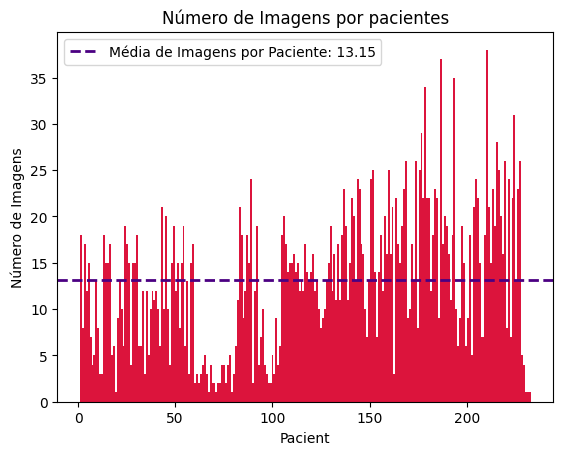

Média de imagens por pacientes: 13.150214592274677


In [ ]:
# Número de imagens por paciente
n_imgs_pacient = np.array([len(grouped_pacients[idx]) for idx in pacients_idx])

# Printando um histograma de imagens para cada paciente
plt.hist(pacients_idx,bins=len(pacients_idx),color='crimson',weights=n_imgs_pacient)
plt.axhline(n_imgs_pacient.mean(), color='indigo', linestyle='dashed', linewidth=2, label=f'Média de Imagens por Paciente: {n_imgs_pacient.mean():.2f}')
plt.legend()
plt.xlabel('Pacient')
plt.ylabel('Número de Imagens')
plt.title('Número de Imagens por pacientes')
plt.show()

# Printando a média de imagens por paciente
print(f'Média de imagens por pacientes: {n_imgs_pacient.mean()}')


### Análise da distribuição das classes

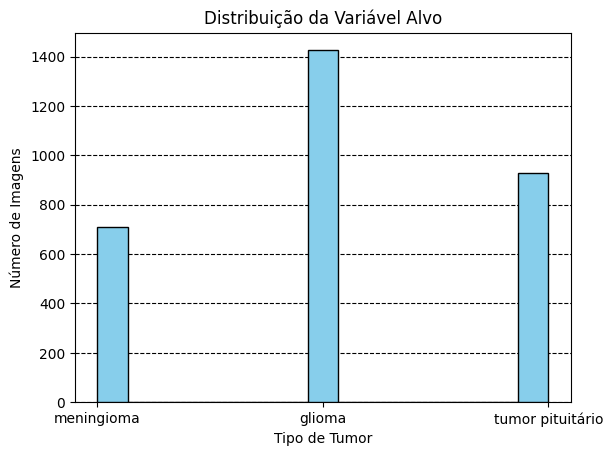

In [ ]:
# Plotando o histograma da distribuição de labels
plt.hist(label_array, bins='auto', color='skyblue',edgecolor='k',zorder=3)
plt.title('Distribuição da Variável Alvo')
plt.xlabel('Tipo de Tumor')
plt.ylabel('Número de Imagens')
plt.xticks(np.unique(label_array),[decod_label[0], decod_label[1], decod_label[2]])
plt.grid(axis='y',zorder=0,linestyle='--',color='black')
plt.show()

In [ ]:
# Teste se todos os pacientes mantém seus respectivos diagnósticos
diagnostics_were_ok = True

for pacient, indices in grouped_pacients.items():
  single_pacient_labels = np.array(label_array)[indices]
  if not np.all(single_pacient_labels[0] == single_pacient_labels):
    diagnostics_were_ok = False
    print(f'Diagnósticos dos pacientes mudaram em diferentes imagens, aconteceu no paciente {pacient}')

if(diagnostics_were_ok):
  print('Os diagnósticos dos pacientes se mantém iguais em todas as imagens')

Os diagnósticos dos pacientes se mantém iguais em todas as imagens


### Removendo variáveis desnecessárias

In [ ]:
del mat_data,pacients,pid_array,pacients_dict,ordinal_mapping,n_imgs_pacient

## Separando os pacientes em grupos de treino,validação e teste

In [ ]:
random_state = 7

# Separando os conjuntos de dados
pacients_train_val, pacients_test = train_test_split(pacients_idx, test_size=50,random_state=random_state)
pacients_train, pacients_val = train_test_split(pacients_train_val, test_size=50,random_state=random_state)

# Printando os tamanhos de cada conjunto.
# Lembrando que são apenas os pacientes, depois será criado o dataset real com as imagens.
# Sendo elas de acordo com os pacientes em cada grupo
print(f'Número de pacientes no conjunto de teste:  {len(pacients_test)}')
print(f'Número de pacientes no conjunto de validação: {len(pacients_val)}')
print(f'Número de pacientes no conjunto de treinamento: {len(pacients_train)}')

Número de pacientes no conjunto de teste:  50
Número de pacientes no conjunto de validação: 50
Número de pacientes no conjunto de treinamento: 133


## Pré-processamento das imagens

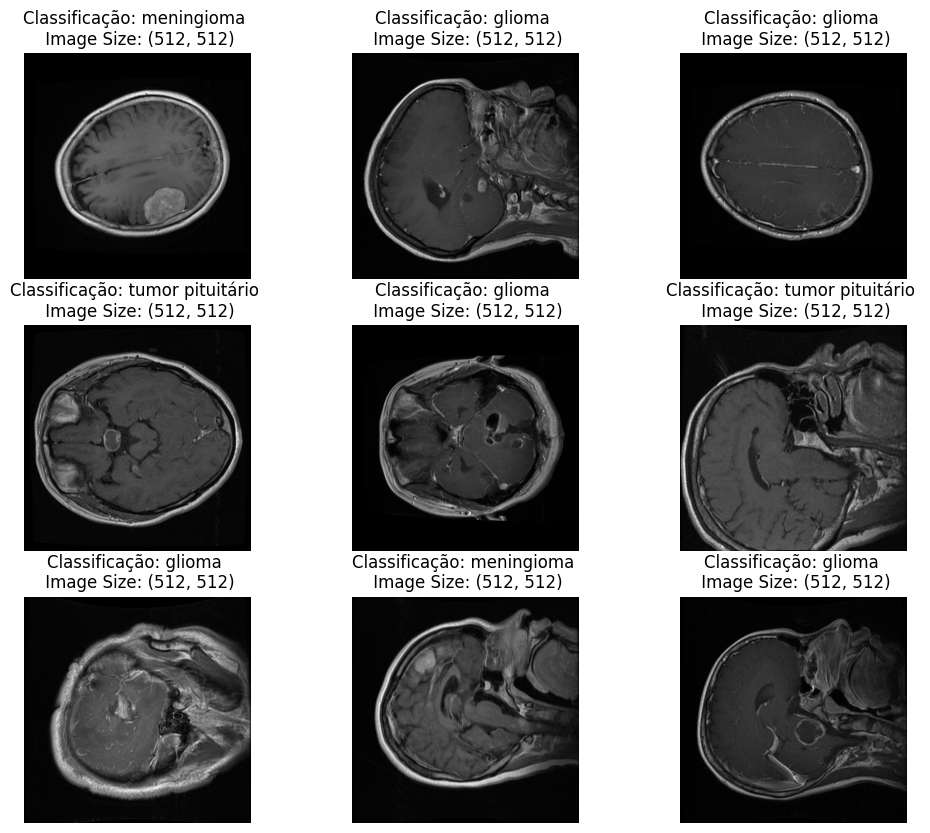

In [ ]:
# Plotando imagens como vieram do dataset
samples = np.random.choice(np.arange(0,3064,1), size=9, replace=False)
plt.figure(figsize=(12, 10))
for index, sample in enumerate(samples):
    if index == 9:
      break
    plt.subplot(3,3, 1+index)
    plt.imshow(img_array[sample],cmap='gray')
    plt.title(f"Classificação: {decod_label[label_array[sample]]} \n Image Size: {img_array[sample].shape}")
    plt.axis('off')
plt.show()

### Reformatando as imagens para se adequar aos modelos

In [ ]:
# Array para salvar os paths para carregar as imagens
paths = []

for idx,img in enumerate(img_array):
  # Convertendo as imagens para uint8 e fazendo min-max
  img = ((img - np.min(img)) / (np.max(img) - np.min(img)) * 255).astype(np.uint8)

  # Transformando as imagens em um tensor
  tf.convert_to_tensor(img, dtype=tf.uint8)

  # Adicionando uma dimensão extra para que os próximos métodos usados funcionem
  img = np.expand_dims(img, axis=-1)

  # Reformatando as imagens para (224,224) devido a entrada dos modelos
  img = tf.image.resize(img,(224,224))

  # Path para salvar os tensores
  path = f'local/tensor-{idx}.npy'

  # Salvando imagem em um arquivo
  np.save(path,img.numpy())

  # Salvando path no array
  paths.append(path)

  # Printando
  print(f'Imagem {idx} salva em: {path} ')



### Função para criar os datasets do tensorflow

In [ ]:
# Função secundária para carregar os arquivos .npy
def __npy_generator(x_,y_):
    for idx,file_path in enumerate(x_):
        tensor = tf.convert_to_tensor(np.load(file_path))
        yield tensor, y_[idx]

# Função para criar os datasets
def create_dataset(__x,__y,batch_size):
  ds = tf.data.Dataset.from_generator(
        generator=lambda: __npy_generator(__x,__y),
        output_signature=(
            tf.TensorSpec(shape=(224,224,1), dtype=tf.float64),
            tf.TensorSpec((),dtype=tf.float64)
        )
    )
  ds = ds.map(lambda x,y: (tf.image.grayscale_to_rgb(x),y))
  ds = ds.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)
  return ds

In [ ]:
# Função secundária para carregar os arquivos .npy
def __npy_generator(x_,y_):
    for idx,file_path in enumerate(x_):
        tensor = tf.convert_to_tensor(np.load(file_path))
        yield tensor, y_[idx]

# Função para criar o dataset de test
def create_test_dataset(__x,__y,batch_size):
  ds = tf.data.Dataset.from_generator(
        generator=lambda: __npy_generator(__x,__y),
        output_signature=(
            tf.TensorSpec(shape=(224,224,1), dtype=tf.float64),
            tf.TensorSpec((),dtype=tf.float64)
        )
    )
  ds = ds.map(lambda x,y: (tf.image.grayscale_to_rgb(x),y))
  return ds

### Finalmente gerando as imagens prontas para criar o dataset do tensorflow


In [ ]:
del samples

## Criando os Datasets com as imagens e labels

### Separando as imagens e labels nos mesmo conjuntos que os pacientes

In [ ]:
# Gerando os conjuntos de treinamento, validação e teste para as imagens e labels
x_train = []
x_val = []
x_test = []
y_train = []
y_val = []
y_test = []

# Treinamento
for idx in pacients_train:
  for imgs in grouped_pacients[idx]:
    x_train.append(paths[imgs])
    y_train.append(label_array[imgs])

# Validação
for idx in pacients_val:
  for imgs in grouped_pacients[idx]:
    x_val.append(paths[imgs])
    y_val.append(label_array[imgs])

# Teste
for idx in pacients_test:
  for imgs in grouped_pacients[idx]:
    x_test.append(paths[imgs])
    y_test.append(label_array[imgs])

# Printando os tamanhos de cada conjunto
print(f'Número de imagens no conjunto de teste:  {len(y_test)}')
print(f'Número de imagens no conjunto de validação: {len(y_val)}')
print(f'Número de imagens no conjunto de treinamento: {len(y_train)}')

print(f'Número total de imagens: {len(y_train)+len(y_val)+len(y_test)}')

Número de imagens no conjunto de teste:  692
Número de imagens no conjunto de validação: 628
Número de imagens no conjunto de treinamento: 1744
Número total de imagens: 3064


# **Definindo Modelos e Hiperparâmetros**

## Definindo Data Augmentations

In [ ]:
# Definindo Data Augmentations que variam apenas no nível de contraste

# Fator de contraste = 0
da_contrast_0 = Sequential(
    [
      RandomFlip('horizontal_and_vertical'),
      RandomRotation(0.1),
      RandomZoom(height_factor=0.1, width_factor=0.1),
      RandomTranslation(height_factor=0.1, width_factor=0.1),
    ],
    name='data_augmentation',
)

# Fator de contraste = 0.1%
da_contrast_01 = Sequential(
    [
      RandomFlip('horizontal_and_vertical'),
      RandomRotation(0.1),
      RandomZoom(height_factor=0.1, width_factor=0.1),
      RandomTranslation(height_factor=0.1, width_factor=0.1),
      RandomContrast(0.001)
    ],
    name='data_augmentation',
)

# Fator de contraste = 5%
da_contrast_5 = Sequential(
    [
      RandomFlip('horizontal_and_vertical'),
      RandomRotation(0.1),
      RandomZoom(height_factor=0.1, width_factor=0.1),
      RandomTranslation(height_factor=0.1, width_factor=0.1),
      RandomContrast(0.05)
    ],
    name='data_augmentation',
)

# Fator de contraste = 10%
da_contrast_10 = Sequential(
    [
      RandomFlip('horizontal_and_vertical'),
      RandomRotation(0.1),
      RandomZoom(height_factor=0.1, width_factor=0.1),
      RandomTranslation(height_factor=0.1, width_factor=0.1),
      RandomContrast(0.1)
    ],
    name='data_augmentation',
)

# Fator de contraste = 25%
da_contrast_25 = Sequential(
    [
      RandomFlip('horizontal_and_vertical'),
      RandomRotation(0.1),
      RandomZoom(height_factor=0.1, width_factor=0.1),
      RandomTranslation(height_factor=0.1, width_factor=0.1),
      RandomContrast(0.25)
    ],
    name='data_augmentation',
)

## Definindo os modelos

### VGG-16

In [ ]:
def vgg16_model(trainable=False,DA=None):
  input_shape = (224,224) + (3,)

  base_model = tf.keras.applications.vgg16.VGG16(include_top=False,input_shape=input_shape,pooling='max')
  base_model.trainable = trainable

  i = Input(shape=input_shape)
  x = tf.keras.applications.vgg16.preprocess_input(i)
  x = DA(x)
  x = base_model(x,training=False)

  x = Flatten()(x)
  x = Dense(720,activation='relu')(x)
  x = Dropout(0.15)(x)
  x = Dense(360,activation='relu')(x)
  x = Dropout(0.15)(x)
  x = Dense(360,activation='relu')(x)
  x = Dropout(0.25)(x)
  x = Dense(180,activation='relu')(x)

  x = Dense(3,activation='softmax')(x)
  model = Model(i,x)

  return model

### Resnet152V2

In [ ]:
def resnet_model(trainable=False,DA=None):
  input_shape = (224,224) + (3,)

  base_model = tf.keras.applications.resnet_v2.ResNet152V2(include_top=False,input_shape=input_shape,pooling='max')
  base_model.trainable = trainable

  i = Input(shape=input_shape)
  x = tf.keras.applications.resnet_v2.preprocess_input(i)
  x = DA(x)
  x = base_model(x,training=False)

  x = Flatten()(x)
  x = Dense(720,activation='relu')(x)
  x = Dropout(0.15)(x)
  x = Dense(360,activation='relu')(x)
  x = Dropout(0.15)(x)
  x = Dense(360,activation='relu')(x)
  x = Dropout(0.25)(x)
  x = Dense(180,activation='relu')(x)

  x = Dense(3,activation='softmax')(x)
  model = Model(i,x)

  return model

### InceptionV3

In [ ]:
def inception_model(trainable=False,DA=None):
  input_shape = (224,224) + (3,)

  base_model = tf.keras.applications.inception_v3.InceptionV3(include_top=False,input_shape=input_shape,pooling='max')
  base_model.trainable = trainable

  i = Input(shape=input_shape)
  x = tf.keras.applications.inception_v3.preprocess_input(i)
  x = DA(x)
  x = base_model(x,training=False)

  x = Flatten()(x)
  x = Dense(720,activation='relu')(x)
  x = Dropout(0.15)(x)
  x = Dense(360,activation='relu')(x)
  x = Dropout(0.15)(x)
  x = Dense(360,activation='relu')(x)
  x = Dropout(0.25)(x)
  x = Dense(180,activation='relu')(x)

  x = Dense(3,activation='softmax')(x)
  model = Model(i,x)

  return model

## Função para treinamento

In [ ]:
# Função para treinamento
def train(model,ds_t,ds_v,epochs,lr,verbose=0):
  from tqdm.keras import TqdmCallback
  model.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'], optimizer=Adam(learning_rate=lr))

  start = time.time()
  history = model.fit(ds_t,validation_data=ds_v, epochs=epochs,verbose=verbose)
  end = time.time()

  plots(history)

  print("\n\nTreinamento durou {:.2f} horas.".format((end-start)/3600))

  return history

In [ ]:
# Função para treinamento
def final_training(model,ds_t,epochs,lr,verbose=1):
  from tqdm.keras import TqdmCallback
  model.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'], optimizer=Adam(learning_rate=lr))

  start = time.time()
  history = model.fit(ds_t, epochs=epochs,verbose=verbose)
  end = time.time()

  print("\n\nTreinamento durou {:.2f} horas.".format((end-start)/3600))

  return history

# **Treinamento**


58889256/58889256 [==============================] - 4s 0us/step


Treinamento durou 0.07 horas.


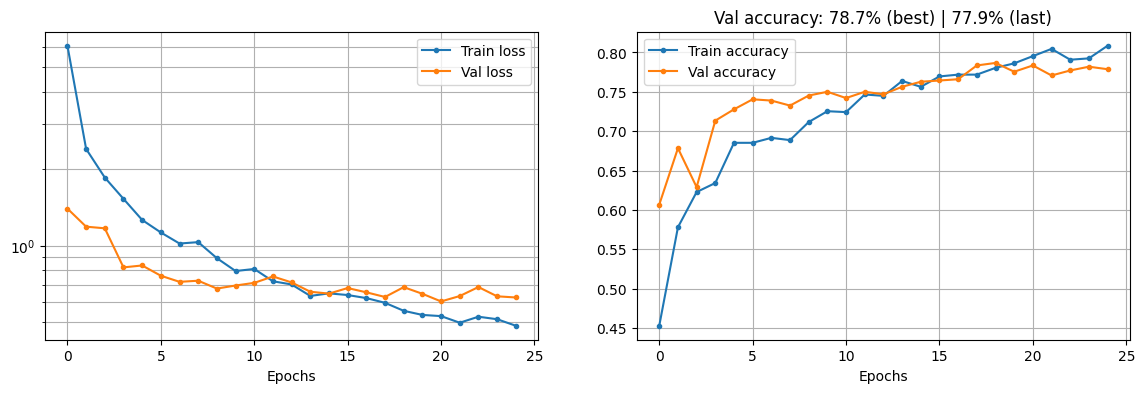

In [ ]:
# Baseline do VGG16
epochs = 25
batch_size = 32

ds_train = create_dataset(x_train,y_train,batch_size)
ds_val = create_dataset(x_val,y_val,batch_size)

model = vgg16_model(trainable=False,DA=da_contrast_0)

train(model,ds_train,ds_val,epochs,lr=1e-4)

234545216/234545216 [==============================] - 9s 0us/step


Treinamento durou 0.14 horas.


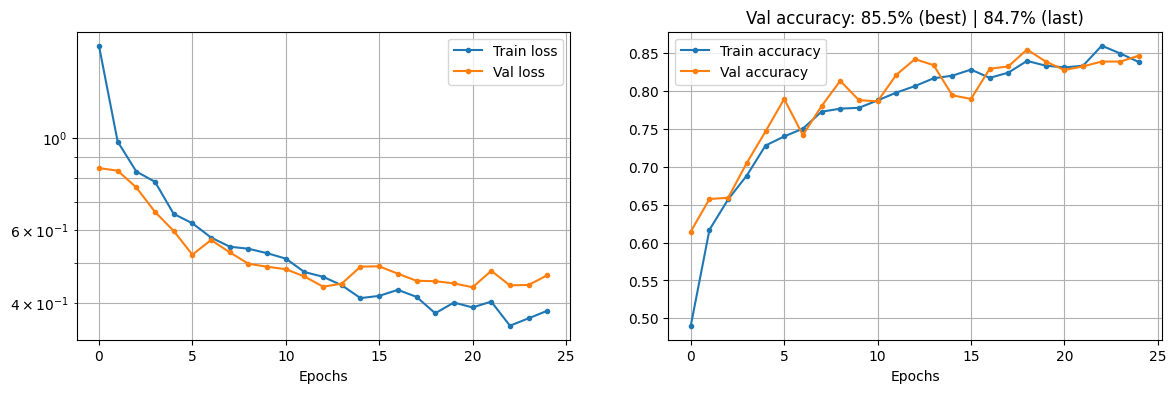

In [ ]:
# Baseline da Resnet
epochs = 25
batch_size = 32

ds_train = create_dataset(x_train,y_train,batch_size)
ds_val = create_dataset(x_val,y_val,batch_size)

model = resnet_model(trainable=False,DA=da_contrast_0)

train(model,ds_train,ds_val,epochs,lr=1e-4)

87910968/87910968 [==============================] - 4s 0us/step


Treinamento durou 0.04 horas.


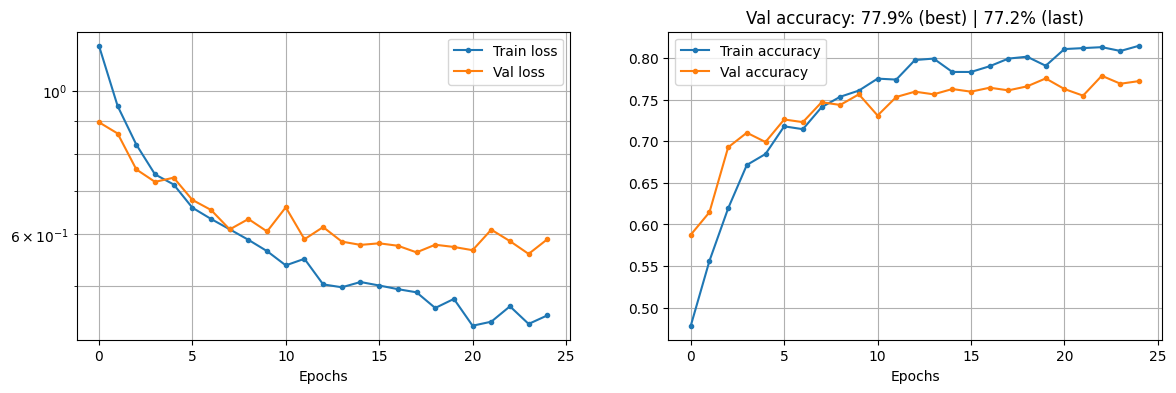

In [ ]:
# Baseline do Inception
epochs = 25
batch_size = 32

ds_train = create_dataset(x_train,y_train,batch_size)
ds_val = create_dataset(x_val,y_val,batch_size)

model = inception_model(trainable=False,DA=da_contrast_0)

train(model,ds_train,ds_val,epochs,lr=1e-4)

## Treinamento do **VGG16**



Treinamento durou 0.19 horas.


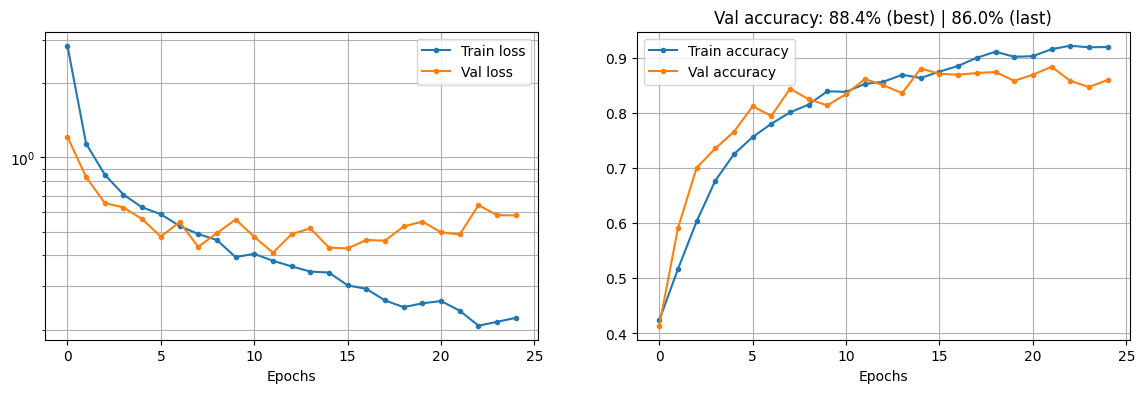

In [ ]:
# Treinamento do VGG16 - Com pesos descongelados e fator de contraste de 0%
epochs = 25
batch_size = 32

ds_train = create_dataset(x_train,y_train,batch_size)
ds_val = create_dataset(x_val,y_val,batch_size)

model = vgg16_model(trainable=True,DA=da_contrast_0)

train(model,ds_train,ds_val,epochs,lr=1e-5,verbose=0)



Treinamento durou 0.19 horas.


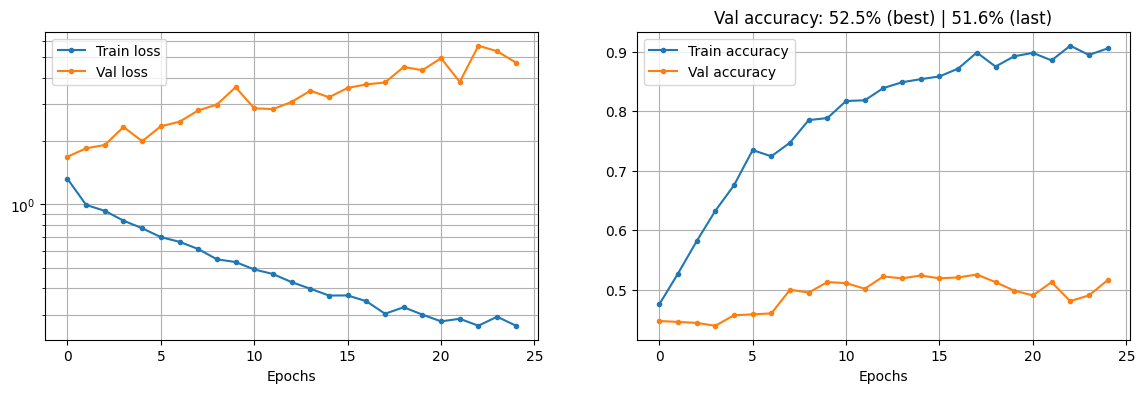

In [ ]:
# Treinamento do VGG16 - Com pesos descongelados e fator de contraste de 0.1%
epochs = 25
batch_size = 32

ds_train = create_dataset(x_train,y_train,batch_size)
ds_val = create_dataset(x_val,y_val,batch_size)

model = vgg16_model(trainable=True,DA=da_contrast_01)

train(model,ds_train,ds_val,epochs,lr=1e-5,verbose=0)



Treinamento durou 0.19 horas.


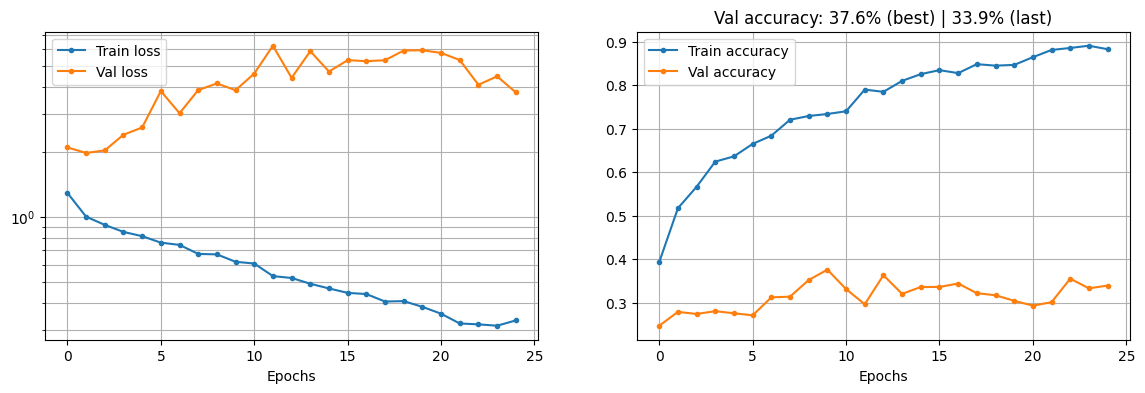

In [ ]:
# Treinamento do VGG16 - Com pesos descongelados e fator de contraste de 10%
epochs = 25
batch_size = 32

ds_train = create_dataset(x_train,y_train,batch_size)
ds_val = create_dataset(x_val,y_val,batch_size)

model = vgg16_model(trainable=True,DA=da_contrast_10)

train(model,ds_train,ds_val,epochs,lr=1e-5,verbose=0)



Treinamento durou 0.19 horas.


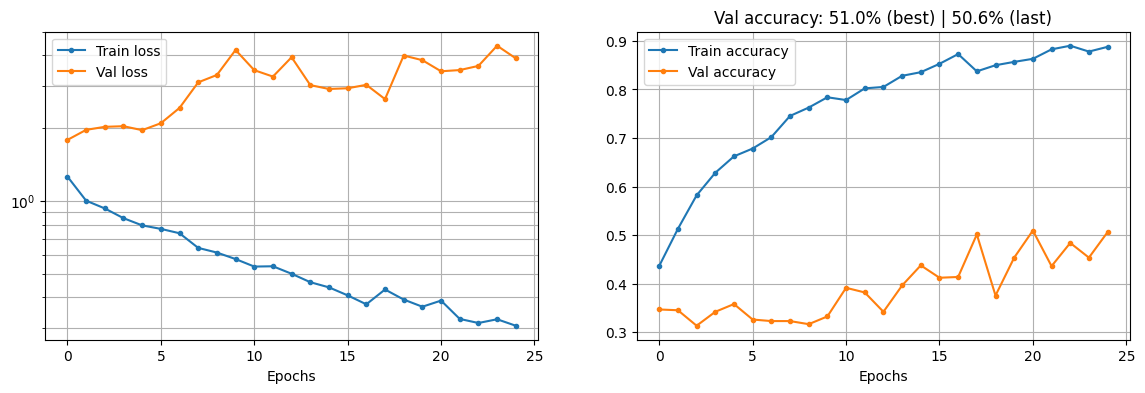

In [ ]:
# Treinamento do VGG16 - Com pesos descongelados e fator de contraste de 25%
epochs = 25
batch_size = 32

ds_train = create_dataset(x_train,y_train,batch_size)
ds_val = create_dataset(x_val,y_val,batch_size)

model = vgg16_model(trainable=True,DA=da_contrast_25)

train(model,ds_train,ds_val,epochs,lr=1e-5,verbose=0)



Treinamento durou 0.19 horas.


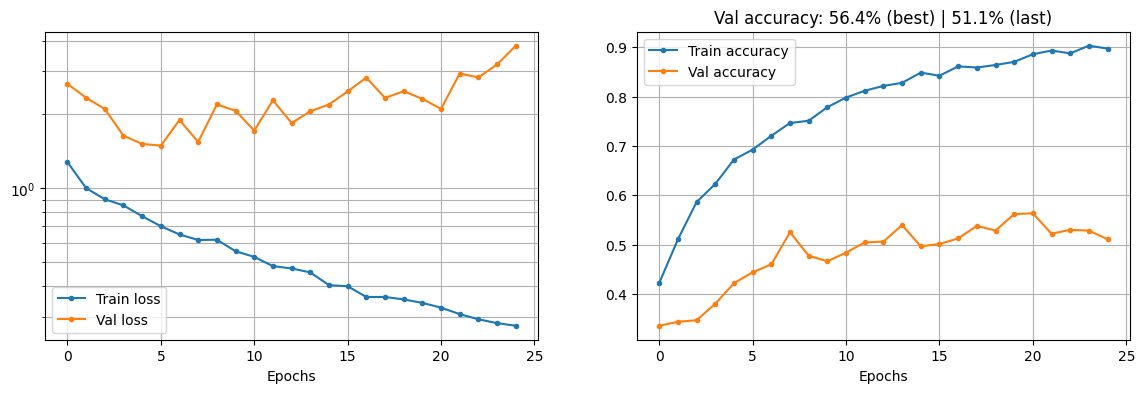

In [ ]:
# Treinamento do VGG16 - Com pesos descongelados e fator de contraste de 5%
epochs = 25
batch_size = 32

ds_train = create_dataset(x_train,y_train,batch_size)
ds_val = create_dataset(x_val,y_val,batch_size)

model = vgg16_model(trainable=True,DA=da_contrast_5)

train(model,ds_train,ds_val,epochs,lr=1e-5,verbose=0)

## Treinamento do **InceptionV3**



Treinamento durou 0.11 horas.


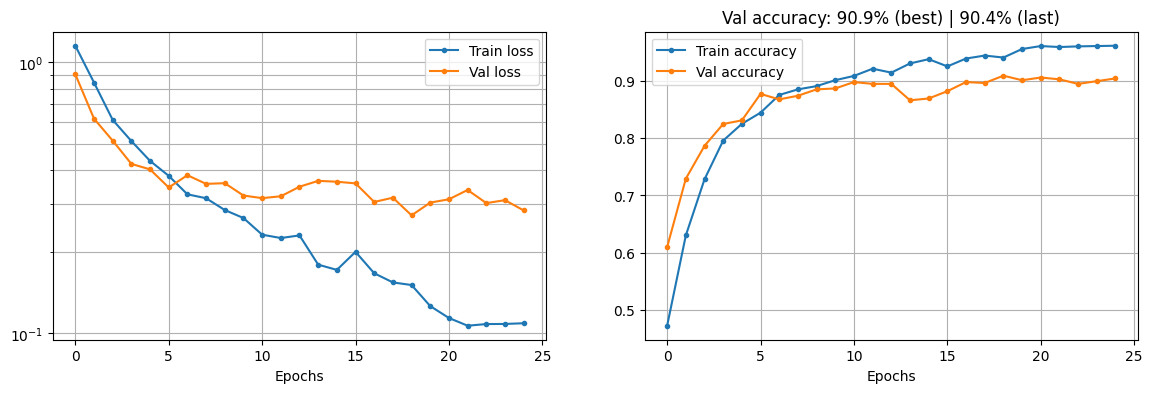

In [ ]:
# Treinamento do Inception - Com pesos descongelados e fator de contraste de 0%
epochs = 25
batch_size = 32

ds_train = create_dataset(x_train,y_train,batch_size)
ds_val = create_dataset(x_val,y_val,batch_size)

model = inception_model(trainable=True,DA=da_contrast_0)

train(model,ds_train,ds_val,epochs,lr=1e-5,verbose=0)



Treinamento durou 0.11 horas.


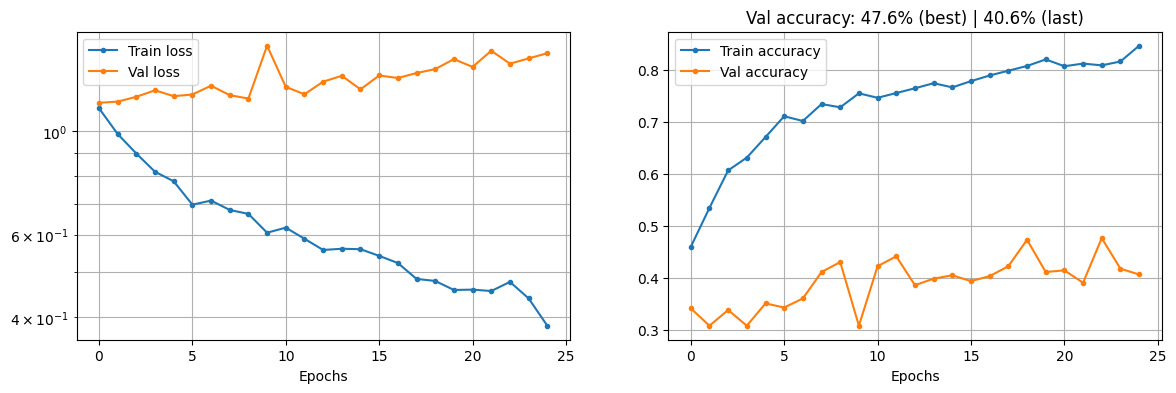

In [ ]:
# Treinamento do Inception - Com pesos descongelados e fator de contraste de 0.1%
epochs = 25
batch_size = 32

ds_train = create_dataset(x_train,y_train,batch_size)
ds_val = create_dataset(x_val,y_val,batch_size)

model = inception_model(trainable=True,DA=da_contrast_01)

train(model,ds_train,ds_val,epochs,lr=1e-5,verbose=0)



Treinamento durou 0.11 horas.


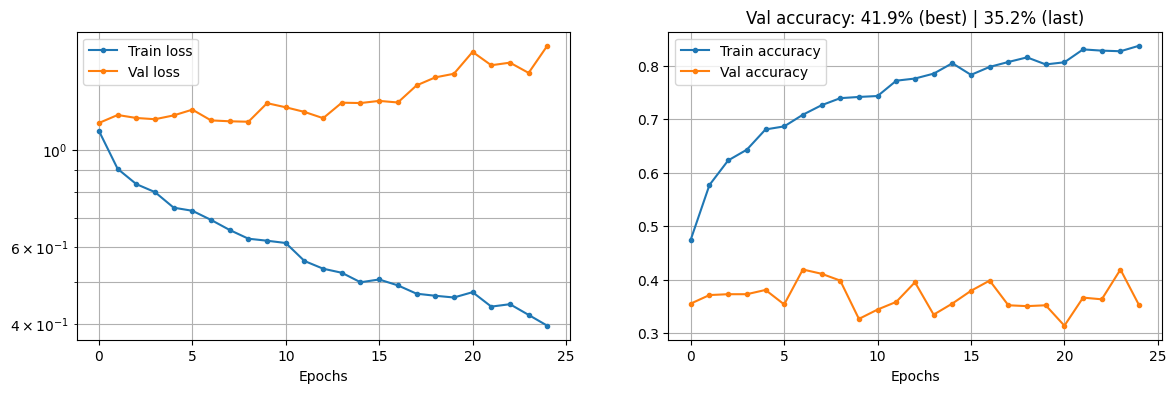

In [ ]:
# Treinamento do Inception - Com pesos descongelados e fator de contraste de 5%
epochs = 25
batch_size = 32

ds_train = create_dataset(x_train,y_train,batch_size)
ds_val = create_dataset(x_val,y_val,batch_size)

model = inception_model(trainable=True,DA=da_contrast_5)

train(model,ds_train,ds_val,epochs,lr=1e-5,verbose=0)



Treinamento durou 0.11 horas.


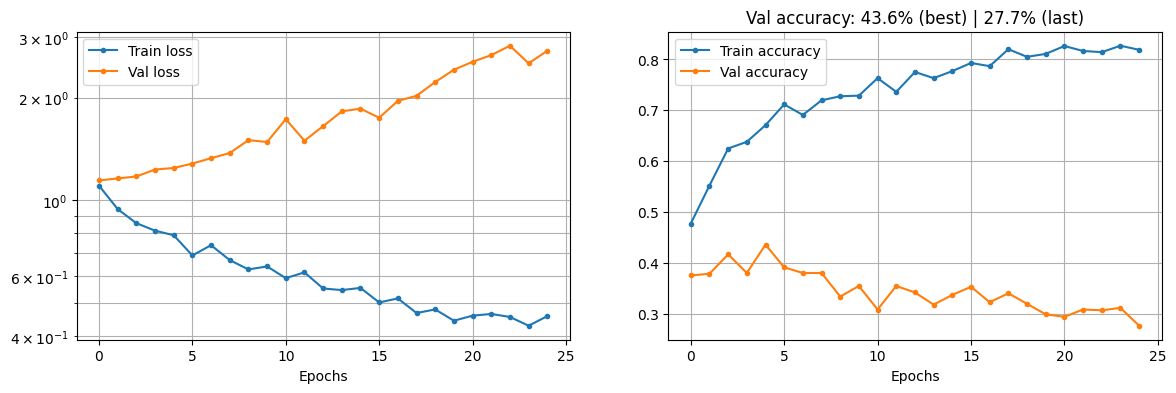

In [ ]:
# Treinamento do Inception - Com pesos descongelados e fator de contraste de 10%
epochs = 25
batch_size = 32

ds_train = create_dataset(x_train,y_train,batch_size)
ds_val = create_dataset(x_val,y_val,batch_size)

model = inception_model(trainable=True,DA=da_contrast_10)

train(model,ds_train,ds_val,epochs,lr=1e-5,verbose=0)



Treinamento durou 0.11 horas.


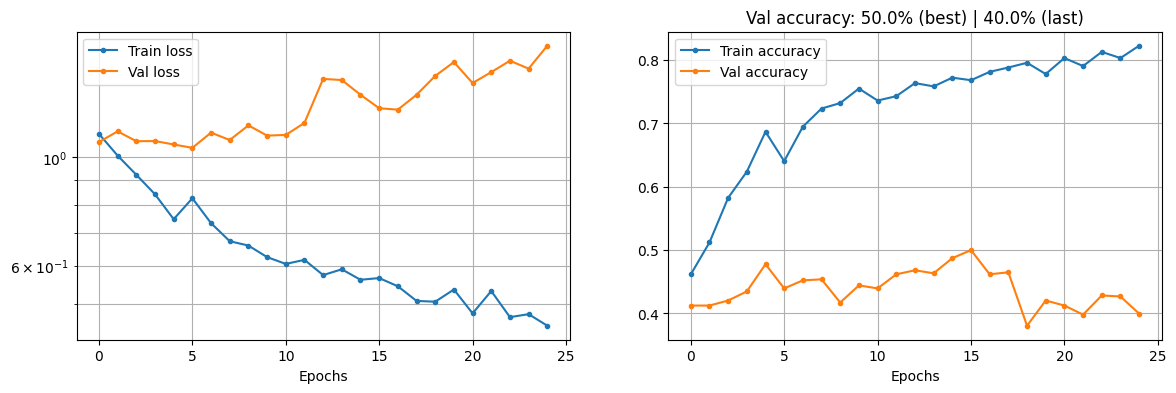

In [ ]:
# Treinamento do Inception - Com pesos descongelados e fator de contraste de 25%
epochs = 25
batch_size = 32

ds_train = create_dataset(x_train,y_train,batch_size)
ds_val = create_dataset(x_val,y_val,batch_size)

model = inception_model(trainable=True,DA=da_contrast_25)

train(model,ds_train,ds_val,epochs,lr=1e-5,verbose=0)

## Treinamento da **Resnet**



Treinamento durou 0.36 horas.


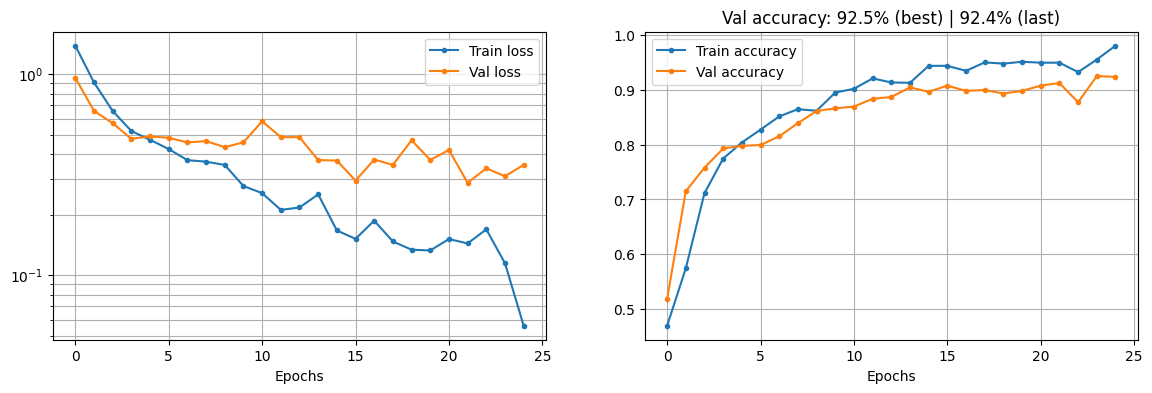

In [ ]:
# Treinamento da Resnet - Com pesos descongelados e fator de contraste de 0%
epochs = 25
batch_size = 32

ds_train = create_dataset(x_train,y_train,batch_size)
ds_val = create_dataset(x_val,y_val,batch_size)

model = resnet_model(trainable=True,DA=da_contrast_0)

train(model,ds_train,ds_val,epochs,lr=1e-5,verbose=0)



Treinamento durou 0.36 horas.


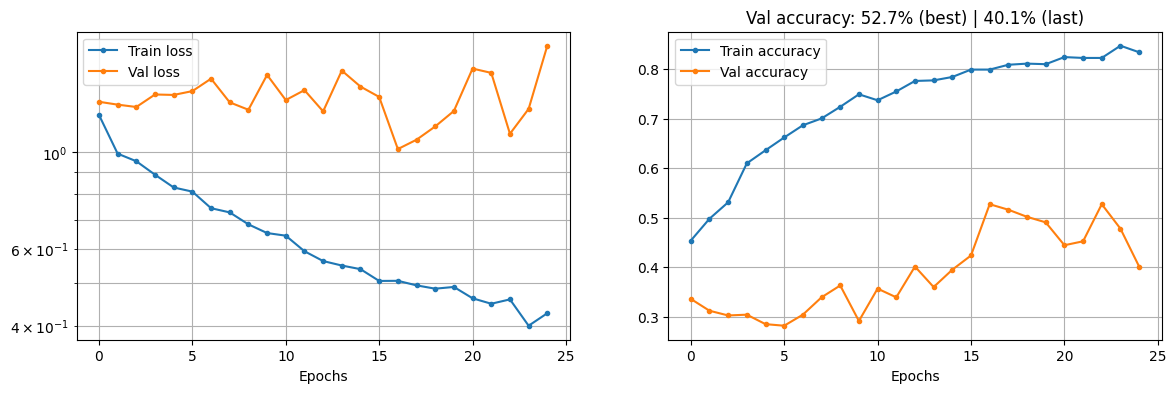

In [ ]:
# Treinamento da Resnet - Com pesos descongelados e fator de contraste de 0.1%
epochs = 25
batch_size = 32

ds_train = create_dataset(x_train,y_train,batch_size)
ds_val = create_dataset(x_val,y_val,batch_size)

model = resnet_model(trainable=True,DA=da_contrast_01)

train(model,ds_train,ds_val,epochs,lr=1e-5,verbose=0)



Treinamento durou 0.36 horas.


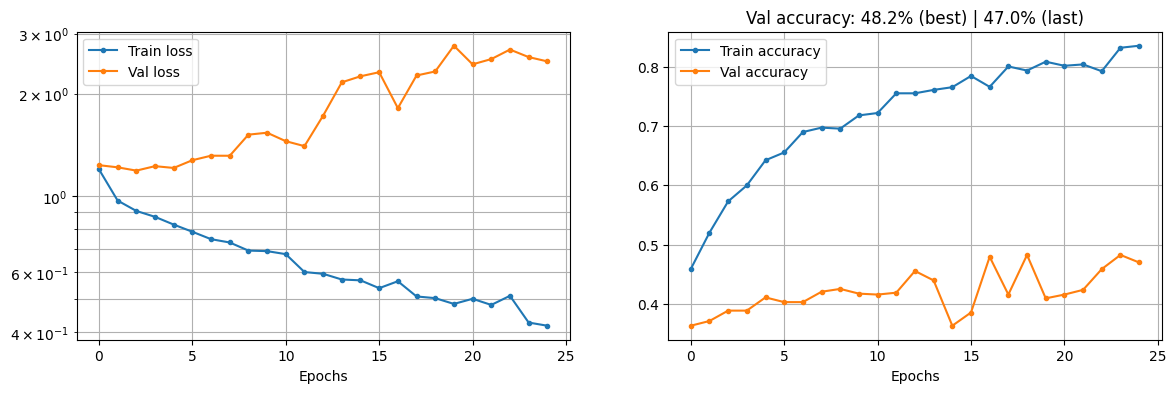

In [ ]:
# Treinamento da Resnet - Com pesos descongelados e fator de contraste de 5%
epochs = 25
batch_size = 32

ds_train = create_dataset(x_train,y_train,batch_size)
ds_val = create_dataset(x_val,y_val,batch_size)

model = resnet_model(trainable=True,DA=da_contrast_5)

train(model,ds_train,ds_val,epochs,lr=1e-5,verbose=0)



Treinamento durou 0.36 horas.


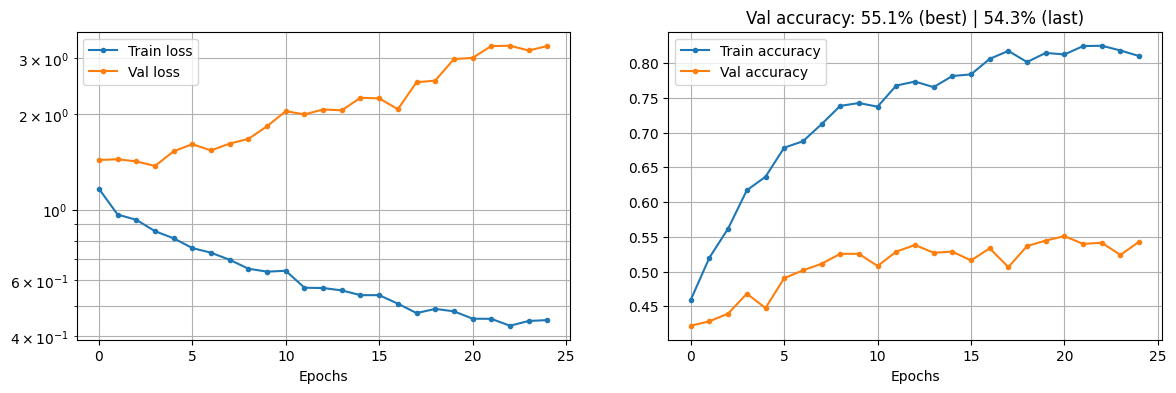

In [ ]:
# Treinamento da Resnet - Com pesos descongelados e fator de contraste de 10%
epochs = 25
batch_size = 32

ds_train = create_dataset(x_train,y_train,batch_size)
ds_val = create_dataset(x_val,y_val,batch_size)

model = resnet_model(trainable=True,DA=da_contrast_10)

train(model,ds_train,ds_val,epochs,lr=1e-5,verbose=0)



Treinamento durou 0.36 horas.


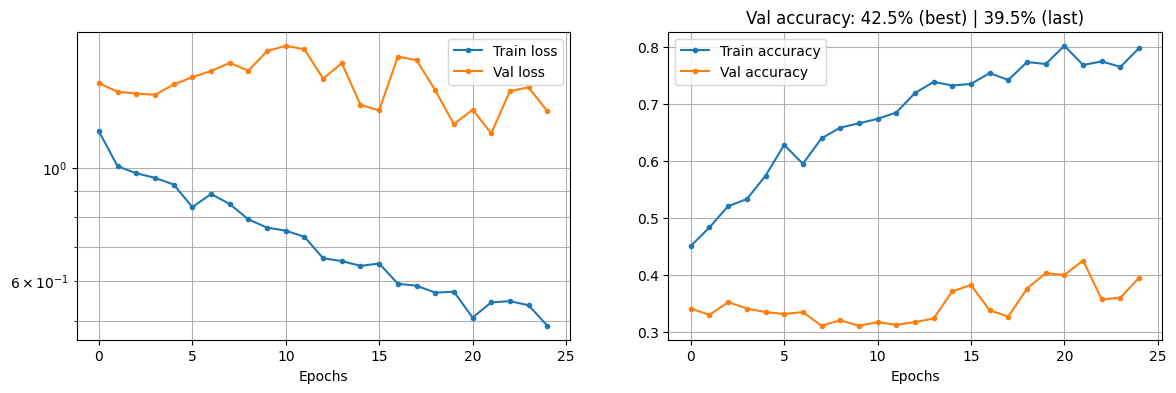

In [ ]:
# Treinamento da Resnet - Com pesos descongelados e fator de contraste de 25%
epochs = 25
batch_size = 32

ds_train = create_dataset(x_train,y_train,batch_size)
ds_val = create_dataset(x_val,y_val,batch_size)

model = resnet_model(trainable=True,DA=da_contrast_25)

train(model,ds_train,ds_val,epochs,lr=1e-5,verbose=0)

### Treinando os Modelos com os melhores hiperparâmetros por mais épocas



Treinamento durou 0.75 horas.


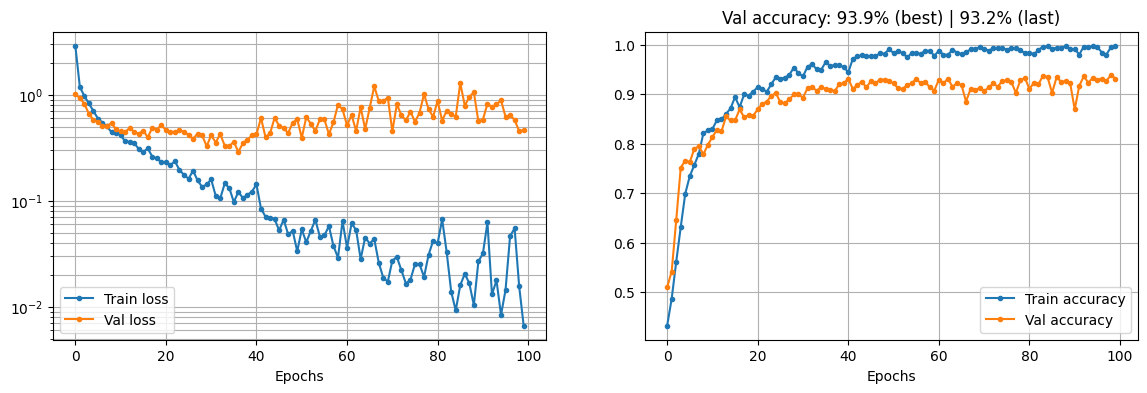

In [ ]:
# Treinamento final do VGG16 com os melhores hiperparâmetros escolhidos
epochs = 100
batch_size = 32

ds_train = create_dataset(x_train,y_train,batch_size)
ds_val = create_dataset(x_val,y_val,batch_size)

model = vgg16_model(trainable=True,DA=da_contrast_0)

train(model,ds_train,ds_val,epochs,lr=1e-5,verbose=0)



Treinamento durou 0.43 horas.


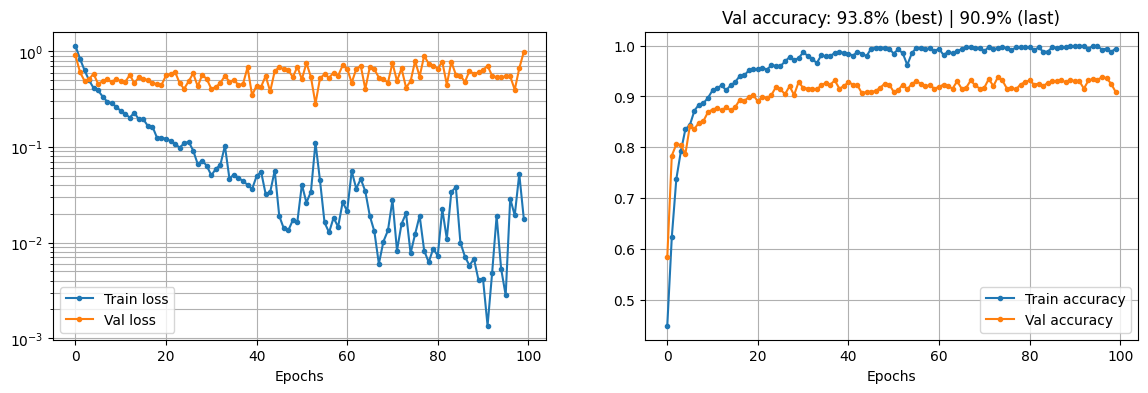

In [ ]:
# Treinamento final do Inception com os melhores hiperparâmetros escolhidos
epochs = 100
batch_size = 32

ds_train = create_dataset(x_train,y_train,batch_size)
ds_val = create_dataset(x_val,y_val,batch_size)

model = inception_model(trainable=True,DA=da_contrast_0)

train(model,ds_train,ds_val,epochs,lr=1e-5,verbose=0)



Treinamento durou 1.37 horas.


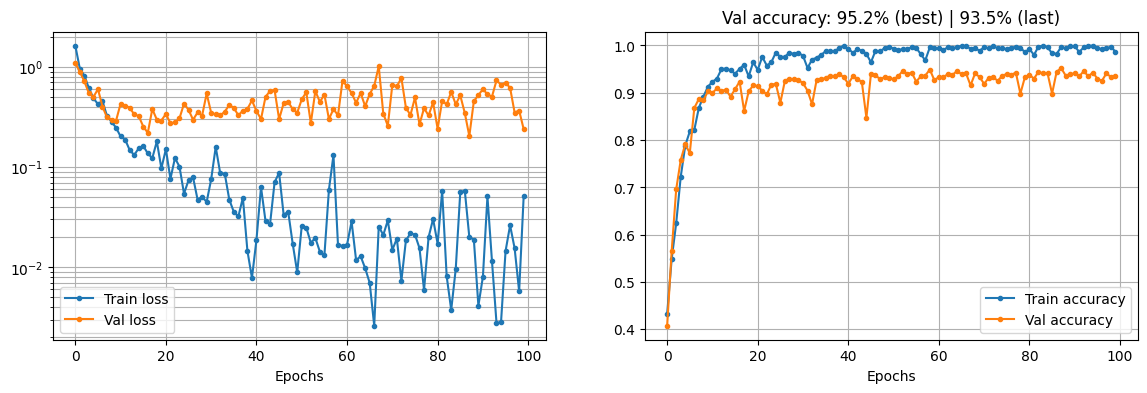

In [ ]:
# Treinamento final da Resnet com os melhores hiperparâmetros escolhidos
epochs = 100
batch_size = 32

ds_train = create_dataset(x_train,y_train,batch_size)
ds_val = create_dataset(x_val,y_val,batch_size)

model = resnet_model(trainable=True,DA=da_contrast_0)

train(model,ds_train,ds_val,epochs,lr=1e-5,verbose=0)

# **Testes e Escolha do Melhor Modelo**

In [ ]:
import warnings

# Juntando os conjuntos de treinamento e validação
x_train_final = np.concatenate((x_train,x_val))
y_train_final = np.concatenate((y_train,y_val))

print(f'Número de imagens no conjunto de teste:  {len(x_test)}')
print(f'Número de imagens no conjunto de treinamento final: {len(x_train_final)}')

print(f'Número total de imagens: {len(x_train_final)+len(x_test)}')

# Criando o dataset de teste
batch_size = 32
ds_test_predict = create_test_dataset(x_test,y_test, batch_size)
ds_test = create_dataset(x_test,y_test, batch_size)

# Criando o x_test_final e y_test_final para realizar o predict
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    x_test_final = np.array([x for x, y in ds_test_predict])
    y_test_final = np.array([y for x, y in ds_test_predict])


Número de imagens no conjunto de teste:  692
Número de imagens no conjunto de treinamento final: 2372
Número total de imagens: 3064


In [ ]:
# Treinamento final do VGG16
epochs = 100
batch_size = 32

ds_train_final = create_dataset(x_train_final,y_train_final,batch_size)

vgg_model = vgg16_model(trainable=True,DA=da_contrast_0)

final_training(vgg_model,ds_train_final,epochs,lr=1e-5)

# Conseguindo a acurácia de teste do modelo
test_acc_ = vgg_model.evaluate(ds_test,verbose=0)[1]

# Printando o desempenho
print(f'Acurácia de Teste -> {test_acc_:.1%}')

# Predição para o cálculo das métricas
y_pred = vgg_model.predict(x_test_final)
y_pred_classes_vgg = np.argmax(y_pred, axis=1)

58889256/58889256 [==============================] - 3s 0us/step
Epoch 1/100
75/75 [==============================] - 58s 459ms/step - loss: 2.5892 - accuracy: 0.4035
Epoch 2/100
75/75 [==============================] - 31s 419ms/step - loss: 1.1093 - accuracy: 0.5042
Epoch 3/100
75/75 [==============================] - 32s 424ms/step - loss: 0.9917 - accuracy: 0.5468
Epoch 4/100
75/75 [==============================] - 32s 420ms/step - loss: 0.8720 - accuracy: 0.6121
Epoch 5/100
75/75 [==============================] - 32s 422ms/step - loss: 0.7710 - accuracy: 0.6678
Epoch 6/100
75/75 [==============================] - 32s 421ms/step - loss: 0.6558 - accuracy: 0.7175
Epoch 7/100
75/75 [==============================] - 32s 421ms/step - loss: 0.5516 - accuracy: 0.7673
Epoch 8/100
75/75 [==============================] - 32s 421ms/step - loss: 0.4950 - accuracy: 0.7968
Epoch 9/100
75/75 [==============================] - 32s 422ms/step - loss: 0.4594 - accuracy: 0.8094
Epoch 10/100
75/7

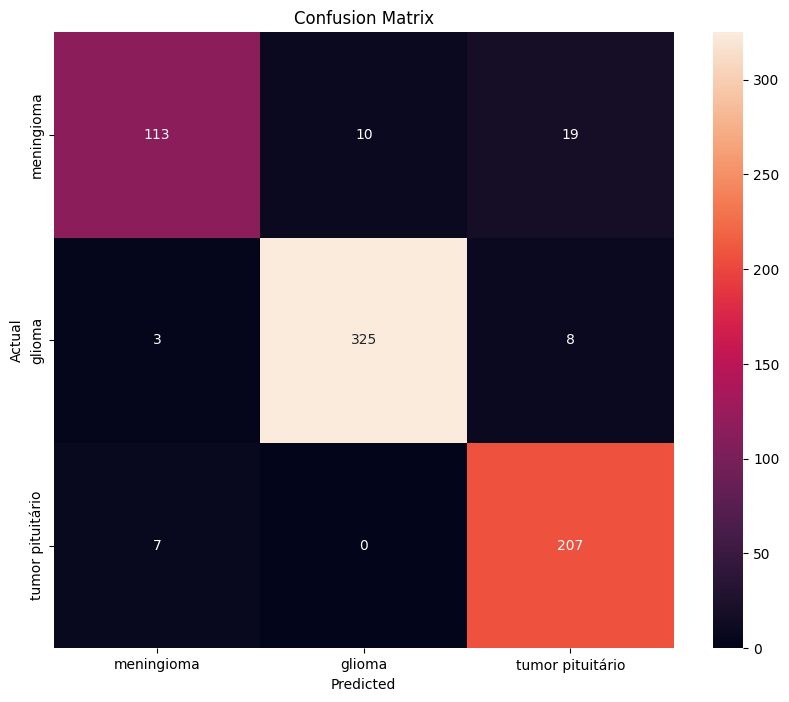

In [ ]:
# Array com os nomes das classes
classes = [decod_label[i] for i in range(3)]

# Plotando a matriz de confusão
conf_mat = confusion_matrix(y_test, y_pred_classes_vgg)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Conseguindo o class report para o teste
class_report = classification_report(y_test, y_pred_classes_vgg, target_names=classes)
print("Classification Report:\n", class_report)

# Conseguindo as métricas para cada classe
precision, recall, f1_score, support = precision_recall_fscore_support(y_test, y_pred_classes_vgg, average='weighted')

print(f'Weighted Average Precision: {precision:.2f}')
print(f'Weighted Average Recall: {recall:.2f}')
print(f'Weighted Average F1-Score: {f1_score:.2f}')

Classification Report:
                   precision    recall  f1-score   support

      meningioma       0.92      0.80      0.85       142
          glioma       0.97      0.97      0.97       336
tumor pituitário       0.88      0.97      0.92       214

        accuracy                           0.93       692
       macro avg       0.92      0.91      0.92       692
    weighted avg       0.93      0.93      0.93       692

Weighted Average Precision: 0.93
Weighted Average Recall: 0.93
Weighted Average F1-Score: 0.93


In [ ]:
# Treinamento final do inception
epochs = 100
batch_size = 32

ds_train_final = create_dataset(x_train_final,y_train_final,batch_size)

inception_model = inception_model(trainable=True,DA=da_contrast_0)

final_training(inception_model,ds_train_final,epochs,lr=1e-5)

# Conseguindo a acurácia de teste do modelo
test_acc_ = inception_model.evaluate(ds_test,verbose=0)[1]

# Printando o desempenho
print(f'Acurácia de Teste -> {test_acc_:.1%}')

# Predição para o cálculo das métricas
y_pred = inception_model.predict(x_test_final)
y_pred_classes_inception = np.argmax(y_pred, axis=1)

87910968/87910968 [==============================] - 3s 0us/step
Epoch 1/100
75/75 [==============================] - 56s 297ms/step - loss: 1.0807 - accuracy: 0.4667
Epoch 2/100
75/75 [==============================] - 19s 247ms/step - loss: 0.7342 - accuracy: 0.6788
Epoch 3/100
75/75 [==============================] - 18s 244ms/step - loss: 0.5423 - accuracy: 0.7917
Epoch 4/100
75/75 [==============================] - 18s 242ms/step - loss: 0.4287 - accuracy: 0.8280
Epoch 5/100
75/75 [==============================] - 18s 244ms/step - loss: 0.3655 - accuracy: 0.8554
Epoch 6/100
75/75 [==============================] - 19s 247ms/step - loss: 0.3494 - accuracy: 0.8727
Epoch 7/100
75/75 [==============================] - 18s 246ms/step - loss: 0.3021 - accuracy: 0.8879
Epoch 8/100
75/75 [==============================] - 18s 245ms/step - loss: 0.2810 - accuracy: 0.8992
Epoch 9/100
75/75 [==============================] - 18s 244ms/step - loss: 0.2803 - accuracy: 0.9001
Epoch 10/100
75/7

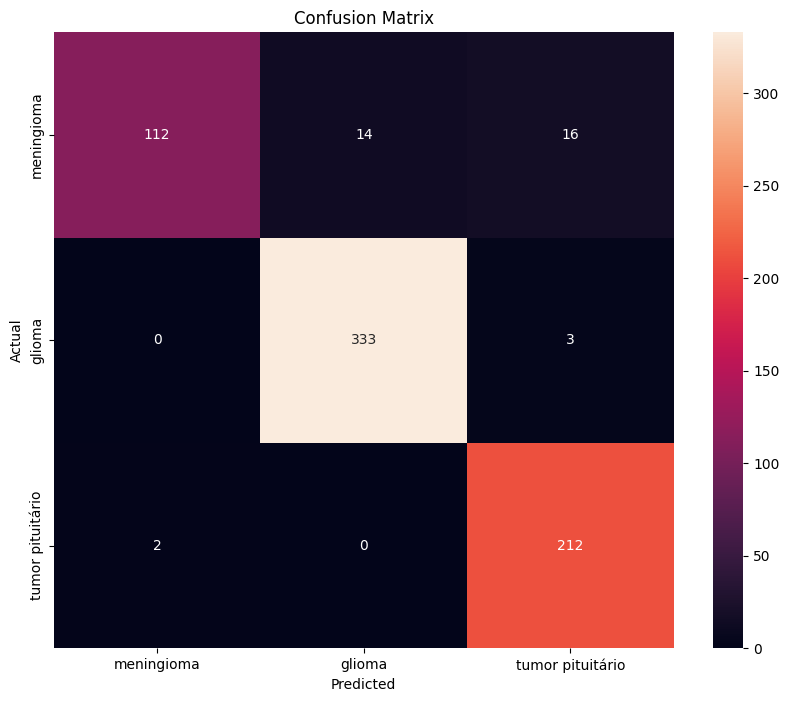

In [ ]:
# Array com os nomes das classes
classes = [decod_label[i] for i in range(3)]

# Plotando a matriz de confusão
conf_mat = confusion_matrix(y_test, y_pred_classes_inception)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Conseguindo o class report para o teste
class_report = classification_report(y_test, y_pred_classes_inception, target_names=classes)
print("Classification Report:\n", class_report)

# Conseguindo as métricas para cada classe
precision, recall, f1_score, support = precision_recall_fscore_support(y_test, y_pred_classes_inception, average='weighted')

print(f'Weighted Average Precision: {precision:.2f}')
print(f'Weighted Average Recall: {recall:.2f}')
print(f'Weighted Average F1-Score: {f1_score:.2f}')

Classification Report:
                   precision    recall  f1-score   support

      meningioma       0.98      0.79      0.88       142
          glioma       0.96      0.99      0.98       336
tumor pituitário       0.92      0.99      0.95       214

        accuracy                           0.95       692
       macro avg       0.95      0.92      0.93       692
    weighted avg       0.95      0.95      0.95       692

Weighted Average Precision: 0.95
Weighted Average Recall: 0.95
Weighted Average F1-Score: 0.95


In [ ]:
# Treinamento final da Resnet
epochs = 100
batch_size = 32

ds_train_final = create_dataset(x_train_final,y_train_final,batch_size)

resnet_model = resnet_model(trainable=True,DA=da_contrast_0)

final_training(resnet_model,ds_train_final,epochs,lr=1e-5)

# Conseguindo a acurácia de teste do modelo
test_acc_ = resnet_model.evaluate(ds_test,verbose=0)[1]

# Printando o desempenho
print(f'Acurácia de Teste -> {test_acc_:.1%}')

# Predição para o cálculo das métricas
y_pred = resnet_model.predict(x_test_final)
y_pred_classes_resnet = np.argmax(y_pred, axis=1)

234545216/234545216 [==============================] - 9s 0us/step
Epoch 1/100
75/75 [==============================] - 144s 805ms/step - loss: 1.3942 - accuracy: 0.4587
Epoch 2/100
75/75 [==============================] - 57s 757ms/step - loss: 0.7687 - accuracy: 0.6610
Epoch 3/100
75/75 [==============================] - 57s 757ms/step - loss: 0.5498 - accuracy: 0.7732
Epoch 4/100
75/75 [==============================] - 57s 759ms/step - loss: 0.4472 - accuracy: 0.8339
Epoch 5/100
75/75 [==============================] - 57s 757ms/step - loss: 0.3388 - accuracy: 0.8769
Epoch 6/100
75/75 [==============================] - 57s 757ms/step - loss: 0.2801 - accuracy: 0.9026
Epoch 7/100
75/75 [==============================] - 57s 758ms/step - loss: 0.2847 - accuracy: 0.9026
Epoch 8/100
75/75 [==============================] - 57s 758ms/step - loss: 0.2253 - accuracy: 0.9216
Epoch 9/100
75/75 [==============================] - 57s 757ms/step - loss: 0.2205 - accuracy: 0.9199
Epoch 10/100
7

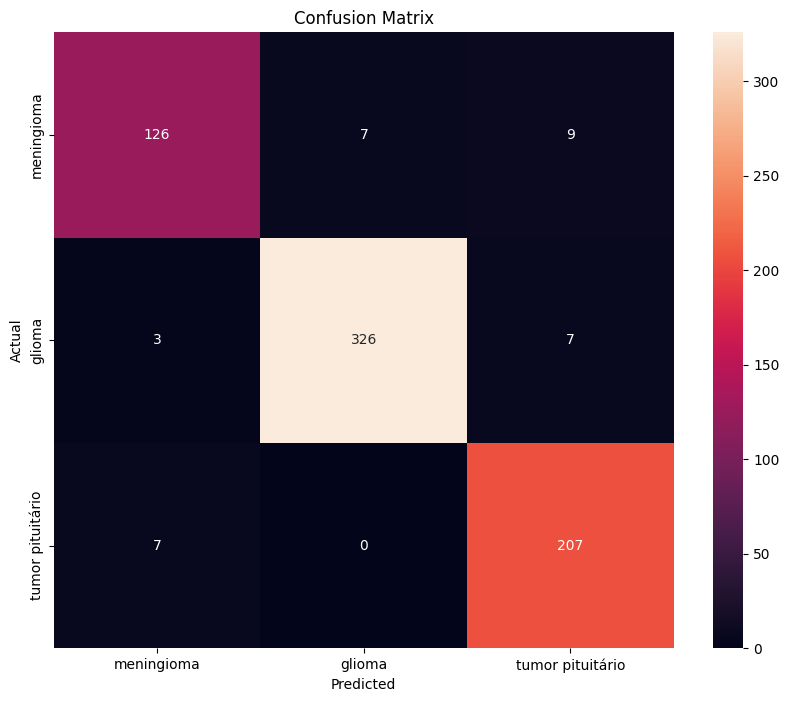

In [ ]:
# Array com os nomes das classes
classes = [decod_label[i] for i in range(3)]

# Plotando a matriz de confusão
conf_mat = confusion_matrix(y_test, y_pred_classes_resnet)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d',xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Conseguindo o class report para o teste
class_report = classification_report(y_test, y_pred_classes_resnet, target_names=classes)
print("Classification Report:\n", class_report)

# Conseguindo as métricas para cada classe
precision, recall, f1_score, support = precision_recall_fscore_support(y_test, y_pred_classes_resnet, average='weighted')

print(f'Weighted Average Precision: {precision:.2f}')
print(f'Weighted Average Recall: {recall:.2f}')
print(f'Weighted Average F1-Score: {f1_score:.2f}')

Classification Report:
                   precision    recall  f1-score   support

      meningioma       0.93      0.89      0.91       142
          glioma       0.98      0.97      0.97       336
tumor pituitário       0.93      0.97      0.95       214

        accuracy                           0.95       692
       macro avg       0.94      0.94      0.94       692
    weighted avg       0.95      0.95      0.95       692

Weighted Average Precision: 0.95
Weighted Average Recall: 0.95
Weighted Average F1-Score: 0.95


# **Domain Shift**

In [ ]:
# Função para criar o dataset do tensorflow do brain dataset para predições
def create_dataset_brain_pred(paths,labels, img_size, batch_size):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    ds = ds.map(lambda x, y: (tf.io.read_file(x), y))
    ds = ds.map(lambda x, y: (tf.io.decode_jpeg(x, channels=3), y))
    ds = ds.map(lambda x, y: (tf.image.resize(x, img_size), y))
    return ds

# Função para criar o dataset do tensorflow do brain dataset
def create_dataset_brain(paths,labels, img_size, batch_size):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    ds = ds.map(lambda x, y: (tf.io.read_file(x), y))
    ds = ds.map(lambda x, y: (tf.io.decode_jpeg(x, channels=3), y))
    ds = ds.map(lambda x, y: (tf.image.resize(x, img_size), y))
    ds = ds.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

In [ ]:
# Carregando o brain dataset
if not os.path.exists('local/braindataset'):
  !rsync --progress "/content/drive/MyDrive/Datasets/brain-dataset.zip" "local/braindataset.zip"
  print('zip copied')

brain-dataset.zip
     67,170,586 100%   55.58MB/s    0:00:01 (xfr#1, to-chk=0/1)
zip copied


In [ ]:
# Descompactando o dataset
if not os.path.exists('local/braindataset'):
  os.mkdir('local/braindataset')
  !unzip "local/braindataset.zip" -d "local/braindataset/"
  print('Dataset unzipped')

In [ ]:
# Variáveis para guardar os labels e paths
directory_path = 'local/braindataset'
braindataset_x = []
braindataset_y = []

# Conseguindo os paths das imagens do dataset
for filename in os.listdir(directory_path):
    if filename.endswith(('.jpg', '.jpeg', '.png', '.gif')):
        # Conseguindo o path absoluto
        file_path = os.path.join(directory_path, filename)
        # Salvando o path
        braindataset_x.append(file_path)
        if 'm' in filename[:-3]:
          braindataset_y.append(0)
        elif 'p' in filename[:-3]:
          braindataset_y.append(2)
        elif 'g' in filename[:-3]:
          braindataset_y.append(1)


In [ ]:
# Criando o dataset do tensorflow
batch_size = 32
ds_brain = create_dataset_brain(braindataset_x,braindataset_y,(224,224), batch_size)
ds_brain_pred = create_dataset_brain_pred(braindataset_x,braindataset_y,(224,224), batch_size)

# Criando o x_brain e y_brain para realizar o predict
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    x_brain = np.array([x for x, y in ds_brain_pred])
    y_brain = np.array([y for x, y in ds_brain_pred])


In [ ]:
# Conseguindo a acurácia do domain shift do modelo
test_acc_ = vgg_model.evaluate(ds_brain,verbose=0)[1]

# Printando o desempenho
print(f'Acurácia de Teste -> {test_acc_:.1%}')

# Predição para o cálculo das métricas
y_pred = vgg_model.predict(x_brain)
y_pred_classes_vgg = np.argmax(y_pred, axis=1)

Acurácia de Teste -> 93.3%
78/78 [==============================] - 10s 130ms/step


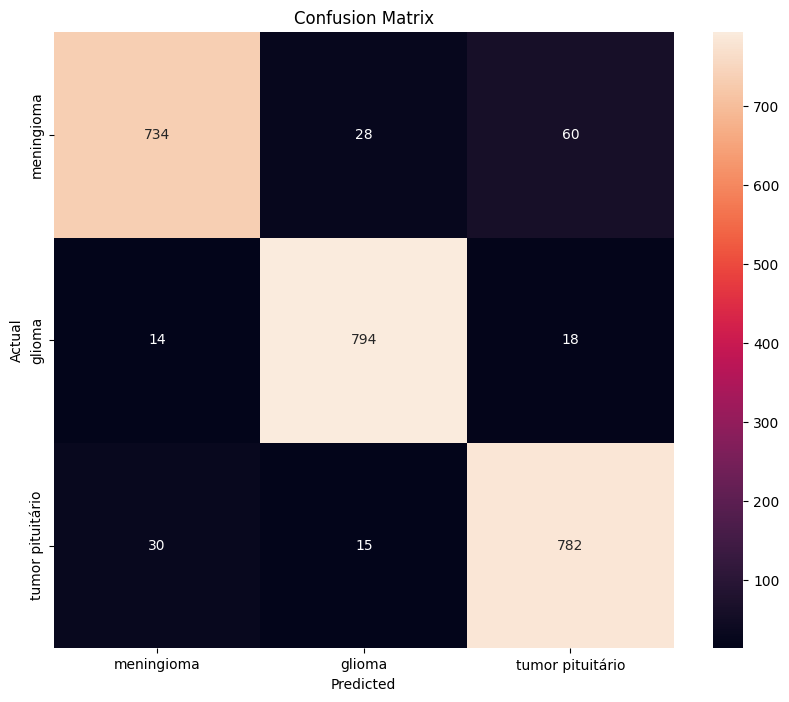

In [ ]:
# Array com os nomes das classes
classes = [decod_label[i] for i in range(3)]

# Plotando a matriz de confusão
conf_mat = confusion_matrix(y_brain, y_pred_classes_vgg)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Conseguindo o class report para o teste
class_report = classification_report(y_brain, y_pred_classes_vgg, target_names=classes)
print("Classification Report:\n", class_report)

# Conseguindo as métricas para cada classe
precision, recall, f1_score, support = precision_recall_fscore_support(y_brain, y_pred_classes_vgg, average='weighted')

print(f'Weighted Average Precision: {precision:.2f}')
print(f'Weighted Average Recall: {recall:.2f}')
print(f'Weighted Average F1-Score: {f1_score:.2f}')

Classification Report:
                   precision    recall  f1-score   support

      meningioma       0.94      0.89      0.92       822
          glioma       0.95      0.96      0.95       826
tumor pituitário       0.91      0.95      0.93       827

        accuracy                           0.93      2475
       macro avg       0.93      0.93      0.93      2475
    weighted avg       0.93      0.93      0.93      2475

Weighted Average Precision: 0.93
Weighted Average Recall: 0.93
Weighted Average F1-Score: 0.93


In [ ]:
# Conseguindo a acurácia do domain shift do modelo
test_acc_ = inception_model.evaluate(ds_brain,verbose=0)[1]

# Printando o desempenho
print(f'Acurácia de Teste -> {test_acc_:.1%}')

# Predição para o cálculo das métricas
y_pred = inception_model.predict(x_brain)
y_pred_classes_inception = np.argmax(y_pred, axis=1)

Acurácia de Teste -> 93.9%
78/78 [==============================] - 5s 67ms/step


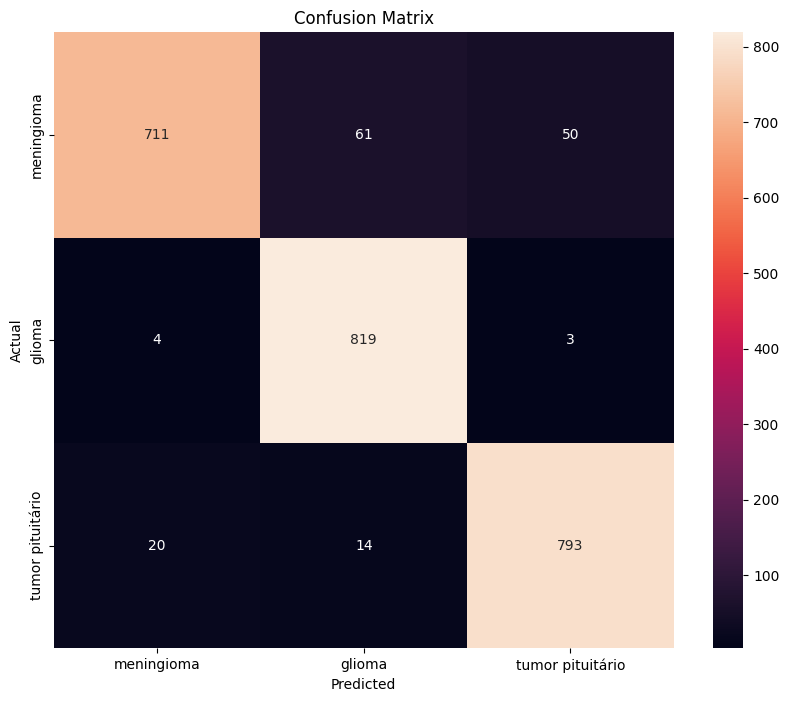

In [ ]:
# Array com os nomes das classes
classes = [decod_label[i] for i in range(3)]

# Plotando a matriz de confusão
conf_mat = confusion_matrix(y_brain, y_pred_classes_inception)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Conseguindo o class report para o teste
class_report = classification_report(y_brain, y_pred_classes_inception, target_names=classes)
print("Classification Report:\n", class_report)

# Conseguindo as métricas para cada classe
precision, recall, f1_score, support = precision_recall_fscore_support(y_brain, y_pred_classes_inception, average='weighted')

print(f'Weighted Average Precision: {precision:.2f}')
print(f'Weighted Average Recall: {recall:.2f}')
print(f'Weighted Average F1-Score: {f1_score:.2f}')

Classification Report:
                   precision    recall  f1-score   support

      meningioma       0.97      0.86      0.91       822
          glioma       0.92      0.99      0.95       826
tumor pituitário       0.94      0.96      0.95       827

        accuracy                           0.94      2475
       macro avg       0.94      0.94      0.94      2475
    weighted avg       0.94      0.94      0.94      2475

Weighted Average Precision: 0.94
Weighted Average Recall: 0.94
Weighted Average F1-Score: 0.94


In [ ]:
# Conseguindo a acurácia do domain shift do modelo
test_acc_ = resnet_model.evaluate(ds_brain,verbose=0)[1]

# Printando o desempenho
print(f'Acurácia de Teste -> {test_acc_:.1%}')

# Predição para o cálculo das métricas
y_pred = resnet_model.predict(x_brain)
y_pred_classes_resnet = np.argmax(y_pred, axis=1)

Acurácia de Teste -> 95.1%
78/78 [==============================] - 17s 227ms/step


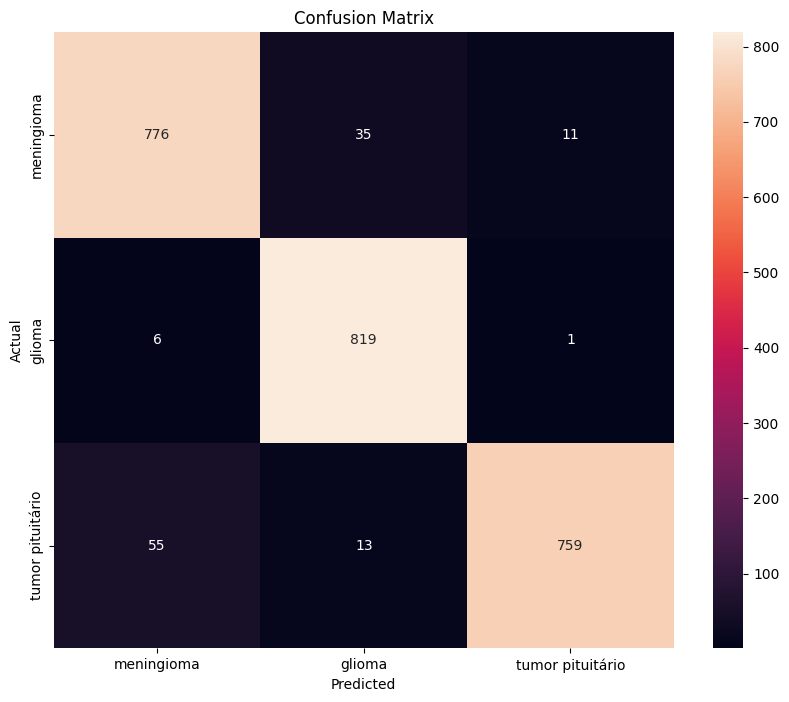

In [ ]:
# Array com os nomes das classes
classes = [decod_label[i] for i in range(3)]

# Plotando a matriz de confusão
conf_mat = confusion_matrix(y_brain, y_pred_classes_resnet)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Conseguindo o class report para o teste
class_report = classification_report(y_brain, y_pred_classes_resnet, target_names=classes)
print("Classification Report:\n", class_report)

# Conseguindo as métricas para cada classe
precision, recall, f1_score, support = precision_recall_fscore_support(y_brain, y_pred_classes_resnet, average='weighted')

print(f'Weighted Average Precision: {precision:.2f}')
print(f'Weighted Average Recall: {recall:.2f}')
print(f'Weighted Average F1-Score: {f1_score:.2f}')

Classification Report:
                   precision    recall  f1-score   support

      meningioma       0.93      0.94      0.94       822
          glioma       0.94      0.99      0.97       826
tumor pituitário       0.98      0.92      0.95       827

        accuracy                           0.95      2475
       macro avg       0.95      0.95      0.95      2475
    weighted avg       0.95      0.95      0.95      2475

Weighted Average Precision: 0.95
Weighted Average Recall: 0.95
Weighted Average F1-Score: 0.95
